In [1]:
# Process Phase - Logging Setup
import logging
import sys

LOG_FILE = "fourth_variable.log"

logging.basicConfig(
    level=logging.INFO,
    filename=LOG_FILE,
    filemode="w",  # Overwrite previous logs on each run
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Redirect print statements to the logger
class LoggerWriter:
    def __init__(self, level):
        self.level = level
    def write(self, message):
        if message.strip():
            self.level(message.strip())
    def flush(self):
        pass

sys.stdout = LoggerWriter(logger.info)
sys.stderr = LoggerWriter(logger.error)

print("=== Logging Setup Complete ===")


In [2]:
# Process Phase - Cell 1: Load Prepared Datasets

import os
import pandas as pd

# Define the path where the prepared datasets are stored
PREPARED_PATH = "./data/prepared/"

# Dictionary mapping dataset names to their prepared file names
files = {
    "pbj_nurse": "pbj_nurse_prepared.parquet",
    "pbj_non_nurse": "pbj_non_nurse_prepared.parquet",
    "qrp_provider": "qrp_provider_prepared.parquet",
    "nh_survey": "nh_survey_prepared.parquet",
    "nh_quality_mds": "nh_quality_mds_prepared.parquet",
    "nh_ownership": "nh_ownership_prepared.parquet",
    "nh_citations": "nh_citations_prepared.parquet"
}

loaded_datasets = {}
for key, filename in files.items():
    file_path = os.path.join(PREPARED_PATH, filename)
    try:
        loaded_datasets[key] = pd.read_parquet(file_path)
        print(f"Loaded {key} with shape {loaded_datasets[key].shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")

# Optionally, check the columns of one dataset to verify
print("Columns in pbj_nurse:", loaded_datasets['pbj_nurse'].columns.tolist())


In [3]:
# Process Phase - Cell 5: Intra-Quarter Staffing Pattern Analysis for Temporary Staffing Ratios

import pandas as pd

# ----------------------------
# Nursing Roles Analysis (from pbj_nurse)
# ----------------------------
nurse_df = loaded_datasets['pbj_nurse']

# Define the nursing columns to include (adjust as needed based on your dataset)
nursing_emp_cols = ["hrs_rn_emp", "hrs_lpn_emp", "hrs_cna_emp"]
nursing_ctr_cols = ["hrs_rn_ctr", "hrs_lpn_ctr", "hrs_cna_ctr"]

# Ensure that only columns that exist are used
existing_nursing_emp = [col for col in nursing_emp_cols if col in nurse_df.columns]
existing_nursing_ctr = [col for col in nursing_ctr_cols if col in nurse_df.columns]

# Create new columns for total nursing employee and contract hours for each record
nurse_df["total_nurse_emp"] = nurse_df[existing_nursing_emp].sum(axis=1)
nurse_df["total_nurse_ctr"] = nurse_df[existing_nursing_ctr].sum(axis=1)

# Group by facility and workdate to compute daily totals per facility
daily_nurse = nurse_df.groupby(["provnum", "workdate"]).agg({
    "total_nurse_emp": "sum",
    "total_nurse_ctr": "sum"
}).reset_index()

# Calculate the daily nursing temporary staffing ratio:
# Ratio = total contract hours / (total employee hours + total contract hours)
daily_nurse["nursing_daily_ratio"] = daily_nurse["total_nurse_ctr"] / (daily_nurse["total_nurse_emp"] + daily_nurse["total_nurse_ctr"])

print("Daily Nursing Temporary Staffing Ratios (first 10 rows):")
print(daily_nurse.head(10))

# Aggregate across facilities to compute an overall daily average nursing ratio
avg_daily_nurse = daily_nurse.groupby("workdate")["nursing_daily_ratio"].mean().reset_index()
avg_daily_nurse.rename(columns={"nursing_daily_ratio": "avg_nursing_daily_ratio"}, inplace=True)

print("Average Daily Nursing Temporary Staffing Ratios (first 10 rows):")
print(avg_daily_nurse.head(10))

# Analyze day-of-week patterns for nursing ratios
avg_daily_nurse["day_of_week"] = avg_daily_nurse["workdate"].dt.day_name()
dow_nurse = avg_daily_nurse.groupby("day_of_week").agg(
    mean_ratio=("avg_nursing_daily_ratio", "mean"),
    std_ratio=("avg_nursing_daily_ratio", "std")
).reset_index()

print("Nursing Temporary Staffing Ratios by Day of Week:")
print(dow_nurse)

# ----------------------------
# Non-Nursing Roles Analysis (from pbj_non_nurse)
# ----------------------------
non_nurse_df = loaded_datasets['pbj_non_nurse']

# Identify non-nursing columns ending in _emp and _ctr
non_nurse_emp_cols = [col for col in non_nurse_df.columns if col.endswith("_emp")]
non_nurse_ctr_cols = [col for col in non_nurse_df.columns if col.endswith("_ctr")]

# Create new columns for total non-nursing employee and contract hours for each record
non_nurse_df["total_non_nurse_emp"] = non_nurse_df[non_nurse_emp_cols].sum(axis=1)
non_nurse_df["total_non_nurse_ctr"] = non_nurse_df[non_nurse_ctr_cols].sum(axis=1)

# Group by facility and workdate to compute daily totals per facility
daily_non_nurse = non_nurse_df.groupby(["provnum", "workdate"]).agg({
    "total_non_nurse_emp": "sum",
    "total_non_nurse_ctr": "sum"
}).reset_index()

# Calculate the daily non-nursing temporary staffing ratio
daily_non_nurse["non_nursing_daily_ratio"] = daily_non_nurse["total_non_nurse_ctr"] / (daily_non_nurse["total_non_nurse_emp"] + daily_non_nurse["total_non_nurse_ctr"])

print("Daily Non-Nursing Temporary Staffing Ratios (first 10 rows):")
print(daily_non_nurse.head(10))

# Aggregate across facilities to compute an overall daily average non-nursing ratio
avg_daily_non_nurse = daily_non_nurse.groupby("workdate")["non_nursing_daily_ratio"].mean().reset_index()
avg_daily_non_nurse.rename(columns={"non_nursing_daily_ratio": "avg_non_nursing_daily_ratio"}, inplace=True)

print("Average Daily Non-Nursing Temporary Staffing Ratios (first 10 rows):")
print(avg_daily_non_nurse.head(10))

# Analyze day-of-week patterns for non-nursing ratios
avg_daily_non_nurse["day_of_week"] = avg_daily_non_nurse["workdate"].dt.day_name()
dow_non_nurse = avg_daily_non_nurse.groupby("day_of_week").agg(
    mean_ratio=("avg_non_nursing_daily_ratio", "mean"),
    std_ratio=("avg_non_nursing_daily_ratio", "std")
).reset_index()

print("Non-Nursing Temporary Staffing Ratios by Day of Week:")
print(dow_non_nurse)

print("=== Intra-Quarter Staffing Pattern Analysis Complete ===")


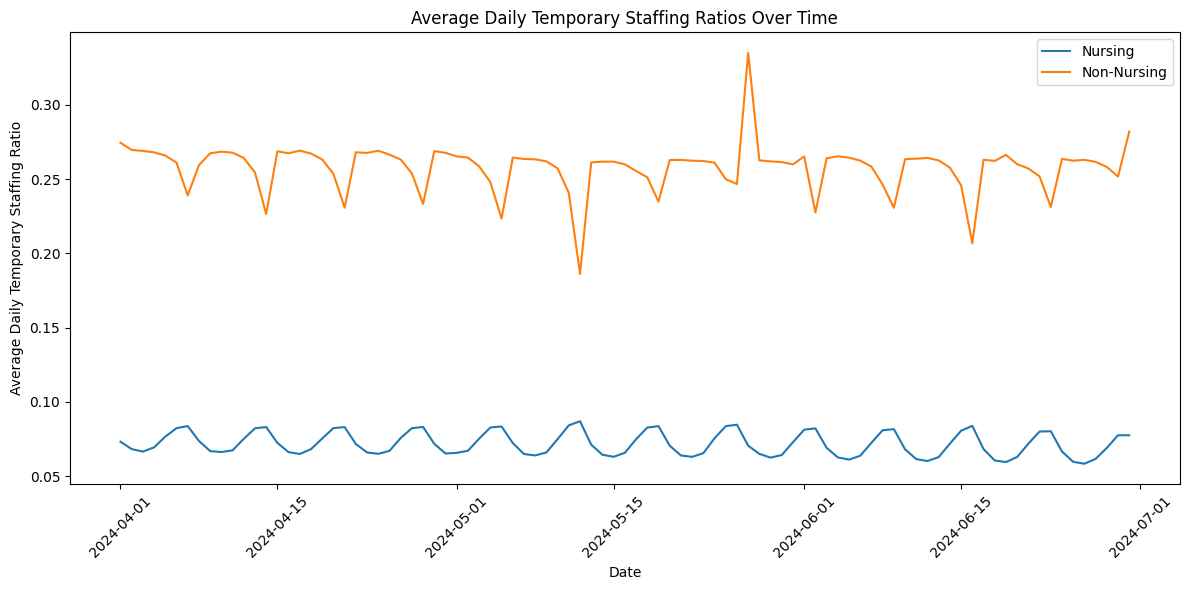

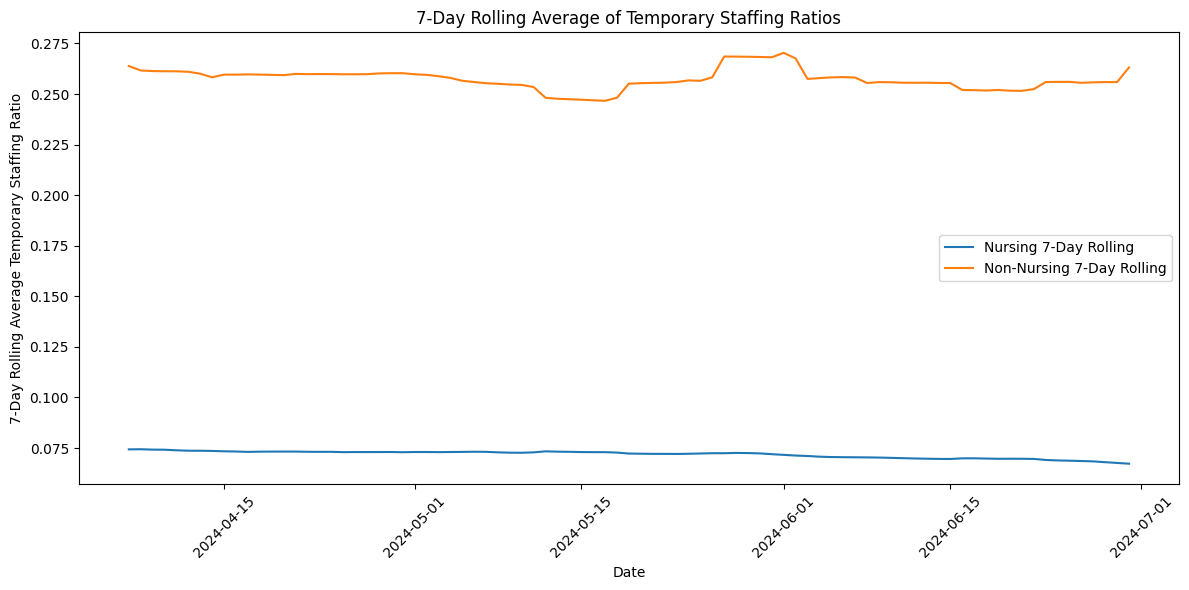

In [4]:
import matplotlib.pyplot as plt

# Plot the overall daily average ratios for nursing and non-nursing roles over time
plt.figure(figsize=(12,6))
plt.plot(avg_daily_nurse['workdate'], avg_daily_nurse['avg_nursing_daily_ratio'], label="Nursing")
plt.plot(avg_daily_non_nurse['workdate'], avg_daily_non_nurse['avg_non_nursing_daily_ratio'], label="Non-Nursing")
plt.xlabel("Date")
plt.ylabel("Average Daily Temporary Staffing Ratio")
plt.title("Average Daily Temporary Staffing Ratios Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute 7-day rolling averages
avg_daily_nurse['rolling_nurse'] = avg_daily_nurse['avg_nursing_daily_ratio'].rolling(window=7).mean()
avg_daily_non_nurse['rolling_non_nurse'] = avg_daily_non_nurse['avg_non_nursing_daily_ratio'].rolling(window=7).mean()

plt.figure(figsize=(12,6))
plt.plot(avg_daily_nurse['workdate'], avg_daily_nurse['rolling_nurse'], label="Nursing 7-Day Rolling")
plt.plot(avg_daily_non_nurse['workdate'], avg_daily_non_nurse['rolling_non_nurse'], label="Non-Nursing 7-Day Rolling")
plt.xlabel("Date")
plt.ylabel("7-Day Rolling Average Temporary Staffing Ratio")
plt.title("7-Day Rolling Average of Temporary Staffing Ratios")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


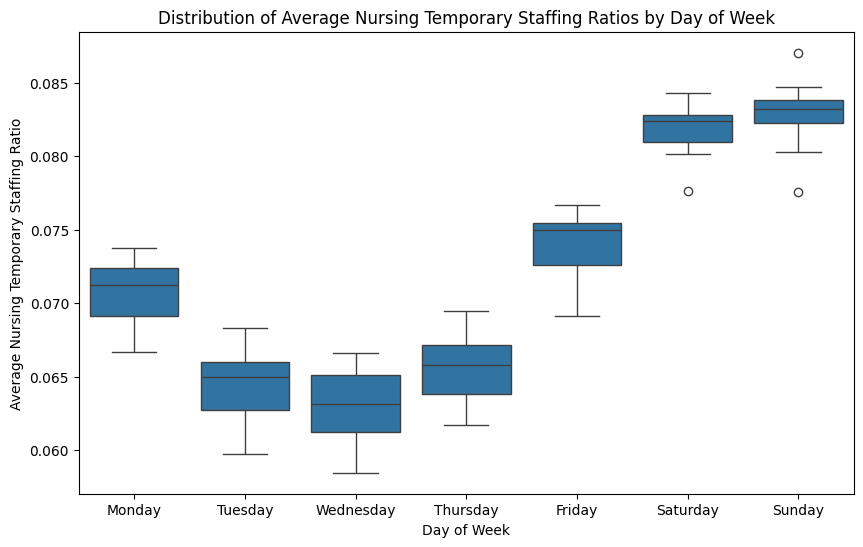

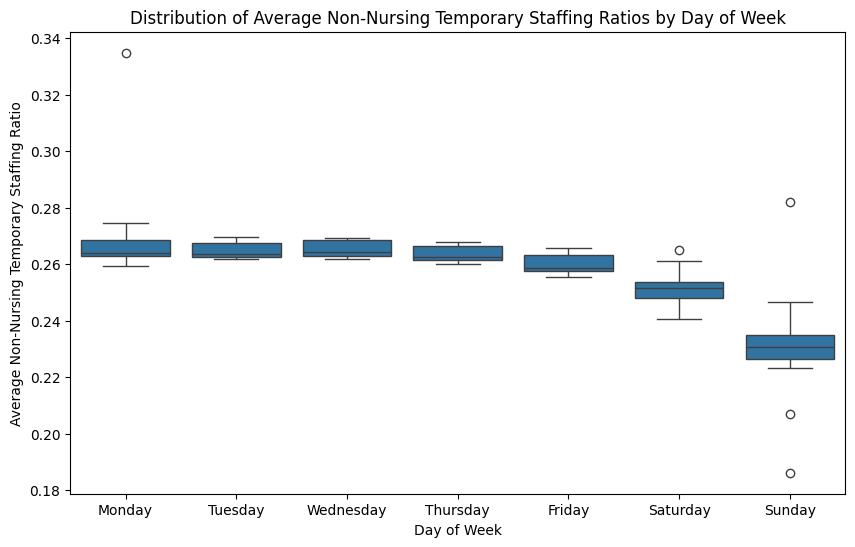

In [5]:
import seaborn as sns

# Boxplot for nursing daily ratios by day of week
plt.figure(figsize=(10,6))
sns.boxplot(x="day_of_week", y="avg_nursing_daily_ratio", data=avg_daily_nurse,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Distribution of Average Nursing Temporary Staffing Ratios by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Nursing Temporary Staffing Ratio")
plt.show()

# Boxplot for non-nursing daily ratios by day of week
plt.figure(figsize=(10,6))
sns.boxplot(x="day_of_week", y="avg_non_nursing_daily_ratio", data=avg_daily_non_nurse,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Distribution of Average Non-Nursing Temporary Staffing Ratios by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Non-Nursing Temporary Staffing Ratio")
plt.show()


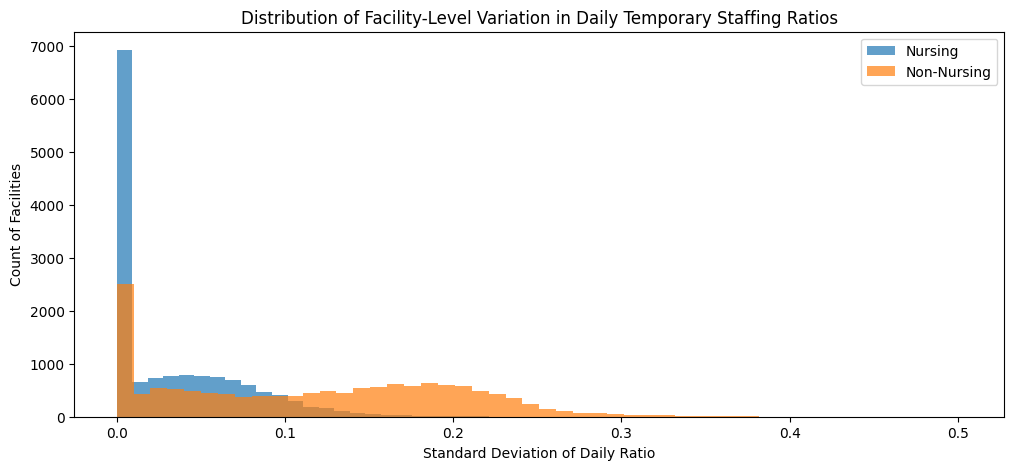

In [6]:
# Compute standard deviation of daily nursing ratios for each facility
facility_nurse_var = daily_nurse.groupby("provnum")["nursing_daily_ratio"].std().reset_index()
facility_nurse_var.rename(columns={"nursing_daily_ratio": "std_nursing_ratio"}, inplace=True)

# Compute standard deviation of daily non-nursing ratios for each facility
facility_non_nurse_var = daily_non_nurse.groupby("provnum")["non_nursing_daily_ratio"].std().reset_index()
facility_non_nurse_var.rename(columns={"non_nursing_daily_ratio": "std_non_nursing_ratio"}, inplace=True)

plt.figure(figsize=(12,5))
plt.hist(facility_nurse_var["std_nursing_ratio"].dropna(), bins=50, alpha=0.7, label="Nursing")
plt.hist(facility_non_nurse_var["std_non_nursing_ratio"].dropna(), bins=50, alpha=0.7, label="Non-Nursing")
plt.xlabel("Standard Deviation of Daily Ratio")
plt.ylabel("Count of Facilities")
plt.title("Distribution of Facility-Level Variation in Daily Temporary Staffing Ratios")
plt.legend()
plt.show()


In [7]:
# Merge daily nursing ratios with the average resident census per facility and day.
# Compute the average resident census from the original nurse_df
daily_nurse_census = nurse_df.groupby(["provnum", "workdate"]).agg({
    "mdscensus": "mean"
}).reset_index()

# Merge with daily_nurse ratios
daily_nurse = daily_nurse.merge(daily_nurse_census, on=["provnum", "workdate"], how="left")

# Calculate overall correlation between nursing temporary staffing ratio and resident census
corr_nurse = daily_nurse["nursing_daily_ratio"].corr(daily_nurse["mdscensus"])
print("Overall correlation between Nursing Temporary Staffing Ratio and Resident Census:", corr_nurse)
